## Setup

In [1]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-12-19 16:53:37,542	INFO worker.py:1812 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8270 


Python version:,3.11.11
Ray version:,2.40.0
Dashboard:,http://127.0.0.1:8270


In [2]:
ray.cluster_resources()

{'CPU': 10.0,
 'object_store_memory': 2147483648.0,
 'node:127.0.0.1': 1.0,
 'node:__internal_head__': 1.0,
 'memory': 17115150746.0}

## Data Preparation

### Data ingestion

In [3]:
import pandas as pd

In [4]:
# Data ingestion
DATASET_LOC = "../datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


### Data Splitting

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [7]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(
    df, stratify=df.tag, test_size=test_size, random_state=1234
)

In [8]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [9]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1 - test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

Exploratory data analysis helps us understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc.) depending on how well the problem is defined.

In [10]:
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
import warnings

warnings.filterwarnings("ignore")
from wordcloud import STOPWORDS, WordCloud

In [11]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

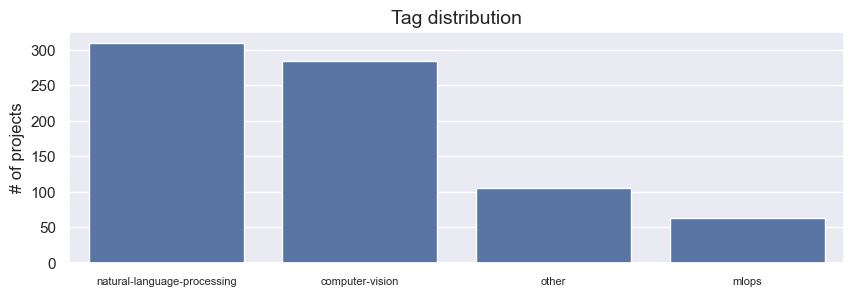

In [12]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

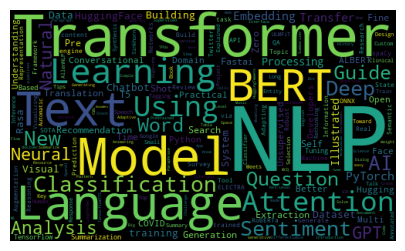

In [13]:
# Most frequent tokens for each tag
tag = "natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag == tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS,
    background_color="black",
    collocations=False,
    width=500,
    height=300,
).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Looks like the title text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the description text feature as well. This information will become useful when we decide how to use our features for modeling.

##  Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we split the data first before preprocessing to avoid data leaks.

In [14]:
import json
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

### Feature engineering

We can combine existing input features to create new meaningful signal (helping the model learn).

In [15]:
df["text"] = df.title + " " + df.description

### Cleaning

In [16]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monkey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string"""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [18]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print(f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [19]:
# DataFrame cleanup
df = df.drop(
    columns=["id", "created_on", "title", "description"], errors="ignore"
)  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Encoding

We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [20]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [21]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [22]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [23]:
index_to_class = {v: k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenize

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a tokenizer that was used for a pretrained LLM (scibert) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [24]:
import numpy as np
from transformers import BertTokenizer

In [25]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained(
    "allenai/scibert_scivocab_uncased", return_dict=False
)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer(
    [text], return_tensors="np", padding="longest"
)  # pad to the longest item in batch
print("input_ids:", encoded_inputs["input_ids"])
print("attention_mask:", encoded_inputs["attention_mask"])
print(tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [26]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained(
        "allenai/scibert_scivocab_uncased", return_dict=False
    )
    encoded_inputs = tokenizer(
        batch["text"].tolist(), return_tensors="np", padding="longest"
    )
    return dict(
        ids=encoded_inputs["input_ids"],
        masks=encoded_inputs["attention_mask"],
        targets=np.array(batch["tag"]),
    )

In [27]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

We'll combine all of our preprocessing steps into function:

In [28]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(
        columns=["id", "created_on", "title", "description"], errors="ignore"
    )  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)
    outputs = tokenize(df)
    return outputs

In [29]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

## Distributed Data Processing

The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [31]:
from scripts.data import stratify_split

In [32]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [33]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2024-12-19 19:10:36,397	INFO dataset.py:2631 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-12-19 19:10:36,404	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-19_16-53-33_786833_13016/logs/ray-data
2024-12-19 19:10:36,404	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(20) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- limit=1 5: 0.00 row [00:00, ? row/s]

[{'id': 549,
  'created_on': datetime.datetime(2020, 4, 16, 3, 48, 35),
  'title': '15 Best Tools for Tracking Machine Learning Experiments',
  'description': 'A feature comparison of all the open-source and commercial options for experiment tracking.',
  'tag': 'mlops'}]

In [34]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [35]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2024-12-19 19:45:45,306	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-19_16-53-33_786833_13016/logs/ray-data
2024-12-19 19:45:45,307	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[Project] -> AllToAllOperator[Aggregate]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(20) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Project 12: 0.00 row [00:00, ? row/s]

- Aggregate 13: 0.00 row [00:00, ? row/s]

Sort Sample 14:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 15:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 16:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

2024-12-19 19:45:45,521	WARNING progress_bar.py:120 -- Truncating long operator name to 100 characters. To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.


In [38]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2024-12-19 19:48:11,621	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-19_16-53-33_786833_13016/logs/ray-data
2024-12-19 19:48:11,621	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(20) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(preprocess) 12: 0.00 row [00:00, ? row/s]

- limit=1 13: 0.00 row [00:00, ? row/s]

{'ids': array([  102,  2389, 29477,  3254,  1572,  6773,  4459,  3041,   791,
        2389, 29477,  3350,  2389, 21591,  3254,  7398,  1572,  6773,
        9153,  1098,  5751,  1332,   532,  1186,   103,     0,     0,
           0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}
